# Using reinforcement learning and an 'Actor' Policy Gradient to train an NN to hold a Double Inverted Pendulum upright

### Imports

In [77]:
import mujoco_py
import gym
import math
import random
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from IPython import display

%matplotlib inline

- Create Environment

In [108]:
env = gym.make('InvertedDoublePendulum-v2')


## Define Actor Network

In [123]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size_1, hidden_size_2, learning_rate=3e-4):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size_1)
        self.actor_linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.actor_linear3 = nn.Linear(hidden_size_2, num_actions)
    
    def forward(self, state):     
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        policy_dist = self.actor_linear3(policy_dist)

        return policy_dist

## Training Function

In [222]:
def a2c(env):
  
    ac_net = Actor(8,2,256,128)
    ac_optimizer = optim.RMSprop(ac_net.parameters(), lr=learning_rate)
    all_lengths = []
    average_lengths = []
    all_rewards = []

    ac_loss = torch.tensor(0, dtype=float)

    for episode in range(max_episodes):
        
        states = []
        actions = []
        rewards = []

        state = env.reset()
        state = state[:8]
        for steps in range(num_steps):
            policy_dist = ac_net.forward(torch.tensor(state).float())

            mu = policy_dist[0]
            sigma = policy_dist[1]

            # Use net to determine mean and std dev and then do a normal draw for continuous action space
            action = torch.normal(mu, sigma)

            states.append(state)
            actions.append(action)

            new_state, reward, done, _ = env.step([action.detach().numpy()])

            rewards.append(reward)

            state = new_state[:8]
            
            if done or steps == num_steps-1:
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # Compute Loss  
        R_discount = torch.tensor(0)
        ac_loss = torch.tensor(0)
        for t in reversed(range(len(rewards))):
            
            R_discount = torch.tensor(rewards[t]) + GAMMA*R_discount
            
            policy = ac_net.forward(torch.tensor(states[t]).float())
            mu = policy[0]
            sigma = policy[1]
            
            log_prob = torch.log(sigma*torch.tensor(2*np.pi)) + 0.5*((actions[t]-mu)/sigma)**2
            
            ac_loss = ac_loss + log_prob*R_discount

        # Take a step
        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

## Hyperparameters and train and evaluate network

episode: 0, reward: 64.18417362842962, total length: 6, average length: 6.0 
episode: 10, reward: 64.05977596150181, total length: 6, average length: 8.7 
episode: 20, reward: 73.50654817268061, total length: 7, average length: 7.2 
episode: 30, reward: 82.5023304879936, total length: 8, average length: 8.8 
episode: 40, reward: 72.99154694677631, total length: 7, average length: 7.0 
episode: 50, reward: 91.85090028523797, total length: 9, average length: 8.4 
episode: 60, reward: 63.75753036382902, total length: 6, average length: 7.6 
episode: 70, reward: 73.13639647196695, total length: 7, average length: 8.0 
episode: 80, reward: 82.53351692159507, total length: 8, average length: 9.0 
episode: 90, reward: 91.72827855173391, total length: 9, average length: 8.9 
episode: 100, reward: 91.76694994401134, total length: 9, average length: 7.8 
episode: 110, reward: 101.21115373205596, total length: 10, average length: 10.1 
episode: 120, reward: 82.5191240769665, total length: 8, aver

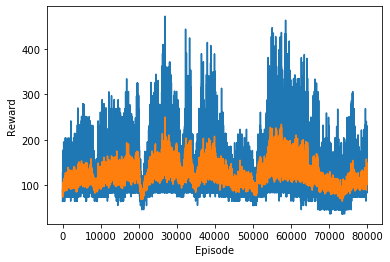

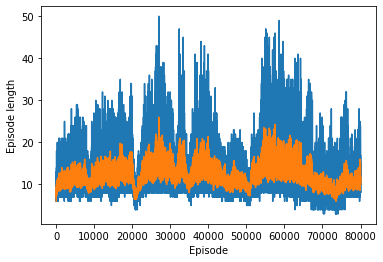

In [225]:
BATCH_SIZE = 32
GAMMA = 0.8
learning_rate = 3e-5
num_steps = 300
max_episodes = 80000

a2c(env)